In [1]:
%matplotlib inline
import numpy as np

caffe_root = '../../../caffe/'

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

/home/mily/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import os
np_loaded_data_file = '../data/train_data_cleaned.npz'
if not os.path.isfile(np_loaded_data_file):
    print "%s does not exist. See facial_recog_kaggle.ipynb" % np_loaded_data_file
else:
    print "loading %s" % np_loaded_data_file
    npzfile = np.load(np_loaded_data_file)
    print "loaded: ", npzfile.files
    X_train_clean_cv, y_train_clean_cv = npzfile['X_train_clean_cv'], npzfile['y_train_clean_cv']
    X_val_clean_cv, y_val_clean_cv = npzfile['X_val_clean_cv'], npzfile['y_val_clean_cv']
    feature_labels = npzfile['feature_labels']
    print X_train_clean_cv.shape, y_train_clean_cv.shape
    print X_val_clean_cv.shape, y_val_clean_cv.shape
    

loading ../data/train_data_cleaned.npz
loaded:  ['X_val_clean_cv', 'y_val_clean_cv', 'y_train_clean_cv', 'feature_labels', 'X_train_clean_cv']
(1640, 1, 96, 96) (1640, 30)
(500, 1, 96, 96) (500, 30)


In [3]:
#Define all params for training
batch_size = 128
base_learning_rate = 1e-4
num_epochs = 50
regularization_param = 5e-4
td_size = X_train_clean_cv.shape[0]
# td_size = 256
val_data_size = X_val_clean_cv.shape[0]
# val_data_size = 2*batch_size

In [4]:
from caffe import layers as L, params as P

def lenet(hdf5_list, batch_size=64):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    
    n.data, n.label = L.HDF5Data(batch_size=batch_size, source=hdf5_list, ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.conv1, in_place=True)
    n.pool1 = L.Pooling(n.relu1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.relu2 = L.ReLU(n.conv2, in_place=True)
    n.pool2 = L.Pooling(n.relu2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    
    n.fc1 =   L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu3 = L.ReLU(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu3, num_output=30, weight_filler=dict(type='xavier'))
    n.loss =  L.EuclideanLoss(n.score, n.label)
    
    return n.to_proto()

train_net_path = 'train_net.prototxt'
test_net_path = 'test_net.prototxt'

with open(train_net_path, 'w') as f:
    f.write(str(lenet(hdf5_list='../data/train_hdf5.list', batch_size=batch_size)))
    
with open(test_net_path, 'w') as f:
    f.write(str(lenet(hdf5_list='../data/test_hdf5.list', batch_size=batch_size)))

In [5]:
from caffe.proto import caffe_pb2
s = caffe_pb2.SolverParameter()

# Set a seed for reproducible experiments:
# this controls for randomization in training.
s.random_seed = 0xCAFFE

# Specify locations of the train and (maybe) test networks.
s.train_net = train_net_path

s.test_net.append(test_net_path)
s.test_iter.append(1) # Test on 100 batches each time we test.

s.test_net.append(train_net_path)
s.test_iter.append(1) # Test on 100 batches each time we test.


s.test_interval = 1000000  # Test after every 500 training iterations.


s.max_iter = 10000     # no. of times to update the net (training iterations)
 
# EDIT HERE to try different solvers
# solver types include "SGD", "Adam", and "Nesterov" among others.
s.type = "Adam"

# Set the initial learning rate for SGD.
s.base_lr = base_learning_rate  # EDIT HERE to try different learning rates
# Set momentum to accelerate learning by
# taking weighted average of current and previous updates.
s.momentum = 0.9
# Set weight decay to regularize and prevent overfitting
s.weight_decay = regularization_param

# Set `lr_policy` to define how the learning rate changes during training.
# This is the same policy as our default LeNet.
s.lr_policy = 'inv'
s.gamma = 0.0001
s.power = 0.75
# EDIT HERE to try the fixed rate (and compare with adaptive solvers)
# `fixed` is the simplest policy that keeps the learning rate constant.
# s.lr_policy = 'fixed'

# Display the current training loss and accuracy every 1000 iterations.
s.display = 2

# Snapshots are files used to store networks we've trained.
# We'll snapshot every 5K iterations -- twice during training.
s.snapshot = 1000000
s.snapshot_prefix = 'lenet_'

s.snapshot_after_train = True

# Train on the GPU
s.solver_mode = caffe_pb2.SolverParameter.CPU


solver_config_fname = 'lenet_solver.prototxt'
# Write the solver to a temporary file and return its filename.
with open(solver_config_fname, 'w') as f:
    f.write(str(s))

In [6]:
%%time

import h5py
f = h5py.File('../data/train_data_lenet.hd5', 'w')
f.create_dataset('data', data=X_train_clean_cv[0:td_size], compression='gzip', compression_opts=4)
f.create_dataset('label', data=y_train_clean_cv[0:td_size], compression='gzip', compression_opts=4)
f.close()

f = h5py.File('../data/test_data_lenet.hd5', 'w')
f.create_dataset('data', data=X_val_clean_cv, compression='gzip', compression_opts=4)
f.create_dataset('label', data=y_val_clean_cv, compression='gzip', compression_opts=4)
f.close()



solver = None
solver = caffe.get_solver(solver_config_fname)

CPU times: user 5.34 s, sys: 225 ms, total: 5.56 s
Wall time: 5.71 s


In [7]:
%%time
solver.step(1)

CPU times: user 12.3 s, sys: 914 ms, total: 13.2 s
Wall time: 7.54 s


In [8]:
%%time
solver.step(1)

CPU times: user 5.74 s, sys: 104 ms, total: 5.84 s
Wall time: 3.28 s


In [9]:
%%time
# solver.step(10)

CPU times: user 9 µs, sys: 1e+03 ns, total: 10 µs
Wall time: 17.9 µs


In [10]:
%%time
if 0:
    td_size = 1
    f = h5py.File('../data/train_data_lenet.hd5', 'w')
    f.create_dataset('data', data=X_train_clean_cv[0:td_size], compression='gzip', compression_opts=4)
    f.create_dataset('label', data=y_train_clean_cv[0:td_size], compression='gzip', compression_opts=4)
    f.close()

    solver = None
    solver = caffe.get_solver(solver_config_fname)

    num_epochs = 100
    num_iter_per_epoch = int(np.ceil(float(td_size) / batch_size))
    niter = num_iter_per_epoch * num_epochs

    #val_data_size = X_val_clean_cv.shape[0]
    val_data_size = 4*batch_size

    print "td_size = %d" % td_size
    print "niter = %d" % niter

    solver.step(niter)

    train_error_check = solver.net.blobs['loss'].data

    print "testing..."

    val_error = 0
    val_error_check = 0
    niter_val = int(np.ceil( float(val_data_size) / batch_size))
    for test_it in range(niter_val):
        solver.test_nets[0].forward()
        val_error += np.sum( (solver.test_nets[0].blobs['score'].data -
                             solver.test_nets[0].blobs['label'].data) ** 2) / (2 * float(val_data_size))
        val_error_check += solver.test_nets[0].blobs['loss'].data / niter_val


    train_error = 0
    for test_it in range(num_iter_per_epoch):
        solver.test_nets[1].forward()
        train_error += np.sum( (solver.test_nets[1].blobs['score'].data -
                             solver.test_nets[1].blobs['label'].data) ** 2) / (2 * float(num_iter_per_epoch * batch_size))

    print "train_error = %f, train_error_check = %f, \
    val_error = %f, val_error_check = %f" % \
            (train_error, train_error_check, val_error, val_error_check)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11 µs


In [11]:
%%time

f = h5py.File('../data/train_data_lenet.hd5', 'w')
f.create_dataset('data', data=X_train_clean_cv[0:td_size], compression='gzip', compression_opts=4)
f.create_dataset('label', data=y_train_clean_cv[0:td_size], compression='gzip', compression_opts=4)
f.close()

solver = None
solver = caffe.get_solver(solver_config_fname)


num_iter_per_epoch = int(np.ceil(float(td_size) / batch_size))
niter = num_iter_per_epoch * num_epochs


niter_val = int(np.ceil( float(val_data_size) / batch_size))
val_interval = num_iter_per_epoch

print "td_size = %d" % td_size
print "niter = %d" % niter
print "val_interval = %d" % val_interval
train_error = np.zeros(niter)
val_error = np.zeros( int(np.ceil(float(niter) / val_interval)))

for it in range(niter):
    solver.step(1)
    
    train_error[it] = solver.net.blobs['loss'].data
    
    if (it % val_interval) == 0:
        
        val_error_this = 0
        for test_it in range(niter_val):
            solver.test_nets[0].forward()
            val_error_this += solver.test_nets[0].blobs['loss'].data / niter_val
        
        val_error[it // val_interval] = val_error_this
        
        print "it = %d, train_error = %f, val_error = %f" % (it, train_error[it], val_error[it // val_interval])

solver.net.save('lenet_trained.caffemodel')

td_size = 1640
niter = 650
val_interval = 13
it = 0, train_error = 47729.621094, val_error = 32176.650391
it = 13, train_error = 2912.139648, val_error = 2672.151306
it = 26, train_error = 1702.012573, val_error = 1537.114777
it = 39, train_error = 1428.376099, val_error = 1165.164490
it = 52, train_error = 1195.271240, val_error = 1003.714630
it = 65, train_error = 1008.609985, val_error = 898.806931
it = 78, train_error = 799.982971, val_error = 831.246124
it = 91, train_error = 646.980957, val_error = 779.351471
it = 104, train_error = 521.101807, val_error = 746.823135
it = 117, train_error = 489.674713, val_error = 707.982315
it = 130, train_error = 432.167877, val_error = 678.523575
it = 143, train_error = 417.156433, val_error = 670.333038
it = 156, train_error = 458.099915, val_error = 645.390808
it = 169, train_error = 456.709869, val_error = 623.274269
it = 182, train_error = 456.143158, val_error = 602.696686
it = 195, train_error = 430.124146, val_error = 602.258240
it = 20

(0, 1000)

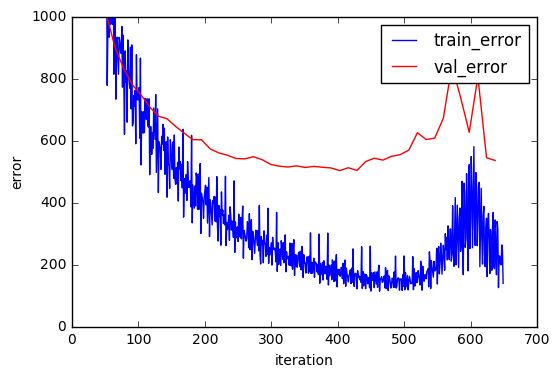

In [12]:
import matplotlib.pyplot as plt

_, ax1 = plt.subplots()
# ax2 = ax1.twinx()
ax1.plot(range(niter), train_error, label='train_error')
ax1.plot(val_interval * np.arange(len(val_error)), val_error, 'r', label='val_error')
ax1.legend()
ax1.set_xlabel('iteration')
ax1.set_ylabel('error')
ax1.set_ylim([0,1000])

In [13]:
print "training_error = %f, val_error = %f" % (train_error[-1], val_error[-1])

training_error = 139.111771, val_error = 535.482018


In [16]:
if 1:
    additional_epochs = 25
    addn_niter = num_iter_per_epoch * additional_epochs
    train_error_2 = np.append(train_error, np.zeros(addn_niter))
    val_error_2 = np.append(val_error, np.zeros(int(np.ceil(float(addn_niter) / val_interval))))

    print "niter = ", niter

    for it in range(niter, niter + addn_niter):
        solver.step(1)

        train_error_2[it] = solver.net.blobs['loss'].data

        if (it % val_interval) == 0:

            val_error_this = 0
            for test_it in range(niter_val):
                solver.test_nets[0].forward()
                val_error_this += solver.test_nets[0].blobs['loss'].data / niter_val

            val_error_2[it // val_interval] = val_error_this

            print "addn_iter = %d, train_error = %f, val_error = %f" % (it, train_error_2[it], val_error_2[it // val_interval])

niter =  650
addn_iter = 650, train_error = 183.800751, val_error = 515.601128
addn_iter = 663, train_error = 120.210579, val_error = 481.774956
addn_iter = 676, train_error = 91.770172, val_error = 481.597389
addn_iter = 689, train_error = 88.543297, val_error = 499.083748
addn_iter = 702, train_error = 78.125610, val_error = 482.137337
addn_iter = 715, train_error = 95.567436, val_error = 493.113892
addn_iter = 728, train_error = 97.013512, val_error = 503.557518
addn_iter = 741, train_error = 94.353760, val_error = 502.597137
addn_iter = 754, train_error = 86.523315, val_error = 498.442520
addn_iter = 767, train_error = 81.215469, val_error = 503.556030
addn_iter = 780, train_error = 70.835159, val_error = 492.912567
addn_iter = 793, train_error = 60.245354, val_error = 505.356171
addn_iter = 806, train_error = 51.011387, val_error = 489.631035
addn_iter = 819, train_error = 48.223869, val_error = 511.196312
addn_iter = 832, train_error = 47.637775, val_error = 498.569031
addn_iter 

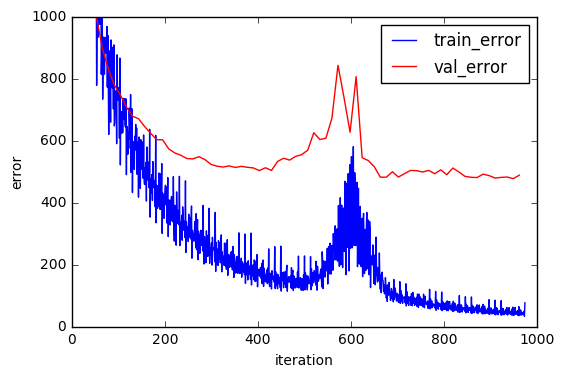

In [19]:
if 1:
    _, ax1 = plt.subplots()
    # ax2 = ax1.twinx()
    ax1.plot(range(len(train_error_2)), train_error_2, label='train_error')
    ax1.plot(val_interval * np.arange(len(val_error_2)), val_error_2, 'r', label='val_error')
    ax1.legend()
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('error')
    ax1.set_ylim([0,1000])

In [23]:
my_net = solver.net
my_net.blobs['data'].data[...] = X_train_clean_cv[0]
my_net.forward()
out = my_net.blobs['score'].data

[[ 65.62869677  38.07669677  31.30590968  39.18348387  59.26234839
   40.29089032  73.37868387  40.29089032  38.22596129  41.39829677]
 [ 66.98038356  35.8118137   32.01139726  36.98728767  61.39726027
   36.10566575  73.44526027  36.39951781  38.77019178  37.86884384]
 [ 69.5802      39.7326      28.8222      37.0512      62.0724      40.5372
   75.2112      40.8054      35.2578      38.6598    ]]


In [26]:
train_error = 0
num_batches = 2
batch_size_used = 128
for it in range(num_batches):
    it_range = range(it*batch_size,it*batch_size+batch_size)
    my_net.blobs['data'].data[...] = X_train_clean_cv[it_range]
    my_net.forward()
    out = my_net.blobs['score'].data
    
    train_error += np.sum( (out - y_train_clean_cv[it_range]) ** 2) / float(2* y_train_clean_cv.shape[1])
train_error = train_error / float(num_batches * batch_size)  

print train_error

12.2385222064
